### Project: Web Scraping of Coinmarketcap website by Karina Oborska

In [463]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import requests
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
%matplotlib inline

In [280]:
def get_list_links(soup):
    '''
    Using Beautiful Soup it extracts all links of the meme coins from the table in each page.

    Args: 
        soup (BeautifulSoup): The BeautifulSoup object containing the parsed HTML.

    Returns:
        the list of formatted strings with the specific part of link which is unique for each meme coin.
    '''
    # Finding the table with the meme coins and accessing its rows
    tbody_meme = soup.find('table', {'class' : 'sc-7b3ac367-3 etbcea cmc-table'}).find('tbody')
    rows = tbody_meme.find_all('tr')
    
    meme_links = []
    
    # Iterating through the rows and extracting the link into the list
    for row in rows:
        name = row.find_all('td')[2].find('a', {'class' : 'cmc-link'})
        link = name['href']
        coin_link = link.split('/')[2]
        meme_links.append(coin_link)

    return meme_links

In [281]:
def all_urls ():
    ''' 
    This function uses Selenium to navigate through the pages of the meme coins and uses the get_list_links() function to extract the links of the meme coins.

    Returns:
        list : complete list of all existing meme coins in the service.
    '''
    # Fetch the first page to determine the number of pages
    meme_page = requests.get('https://coinmarketcap.com/view/memes/')
    soup = BeautifulSoup(meme_page.content, 'html.parser')
    page_number = int(soup.find('div', {'class': 'sc-64f7b75d-0 bdECBy'}).ul.find_all('li')[-2].text)

    # Extract links from the first page with the get_list_links() function
    first_page = get_list_links(soup)

    # Initialize the Chrome driver without opening the browser
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    driver = webdriver.Chrome(options=chrome_options)
    
    # Initializes variables for the while and for loops and for the list of links. Number of attempts to take and time sleep.
    attempts = 0
    a, b = 1, 3 # Starting numbers for time sleep
    rest_pages = []

    while attempts < 3:
        try:
            # Starting from the first page of memecoins
            driver.get('https://coinmarketcap.com/view/memes/')

            for page in range (1, page_number):
                # Scrolling down to ensure all elements are loaded
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

                # Clicking to change the page
                change_page = driver.find_element(By.CSS_SELECTOR, '#__next > div.sc-2e66506f-1.buMEwe.global-layout-v2 > div.main-content > div.cmc-body-wrapper > div > div:nth-child(1) > div.sc-4c05d6ef-0.sc-923566c9-0.dlQYLv.bMxZye > div.sc-923566c9-4.kENPEC.hide_for_narrow > div > ul > li.next > a')
                change_page.click()
                
                # Wait to ensure content is loaded
                time.sleep(random.uniform(a, b))

                # Get the updated page source, parsing it and gathering the links
                page_source = driver.page_source
                soup = BeautifulSoup(page_source, 'html.parser')
                page_list = get_list_links(soup)
                rest_pages.extend(page_list)

            break # Exit the loop if successful

        except Exception as e:
            print(f'Error occurred due to potentially too short time sleep. We increase it and try again. Error details: {e}')
            attempts += 1
            a, b = a + 1, b + 1
            rest_pages = []
            continue

    # Close the driver
    driver.quit()
    complete_list = first_page + rest_pages
    
    return complete_list

In [ ]:
# Using the function to get the complete list of all meme coins
final_list = all_urls()

In [299]:
def format_replace(value):
    '''
    This function is used to format the values from the website to the correct format and replace the symbols to make the data usable.

    Args:
        value (str): The value to be formatted.

    Returns:
        float: The formatted value.
    '''
    # Changing the value to None if it is '--' or '∞'
    if value in ['--', '∞']:
        return None
    
    # Deleting dollar sign and comas to format the value
    value = value.replace('$', '').replace(',', '')

    return float(value)

def extract_format_price(element):
    '''
    This function is used to format prices of memecoins which have number reflects the amount of the 0 after the dot.
    
    Args:
        element (BeautifulSoup): The element to be formatted.
    Returns:
        float: The formatted price.
    '''
    # Finding the span with the abbreviation price
    abbreviation_span = element.find('span', {'class': 'abbreviation-price'})
    
    if abbreviation_span:
        # Beautiful Soup object is converted into string
        price_text = str(abbreviation_span)
    
        # Regular expression is used to find the pattern(0.)
        main_value = re.search(r'\d\.', price_text).group()

        # Regular expression is used to find the pattern, where first number reflects number of 0 after dot(<sub>5</sub>2135)
        sub_value_match = re.search(r'<sub>(\d+)</sub>(\d+)', price_text)
        sub_zeros = int(sub_value_match.group(1))
        sub_number = sub_value_match.group(2)
    
        # Creating final number with the correct amount of zeros
        full_value = f"{main_value}{'0' * sub_zeros}{sub_number}"
        formatted_price = float(full_value)
    else:
        formatted_price = format_replace(element.span.text.strip())
        
    return formatted_price

In [300]:

def get_data(soup):
    '''
    This function parses the data based on Beautiful Soup object and extracts the required data from the meme coin page

    Args:
        object of the BeautifulSoup class

    Returns:
        List of the extracted data
    '''
    data = []
    # Checking if the required data is present on the page to stop parsing for memecoins without data.
    if not soup.find('div', {'class' : 'sc-65e7f566-0 DDohe flexStart alignBaseline'}):
        print("Required data not found, ending the function.")
        return None
    
    # Extracting the data using functions: format_replace() and extract_and_format_price()
    try:
        other_values = soup.find('dl', {'class' : 'sc-65e7f566-0 eQBACe coin-metrics-table'})
        name = soup.find('span', {'data-role' : 'coin-name'})['title']
        price = extract_format_price(soup.find('div', {'class' : 'sc-65e7f566-0 DDohe flexStart alignBaseline'}))
        market_cap = format_replace(other_values.find_all('dd')[0].text.split('%').pop(1))
        volume_24h = format_replace((other_values.find_all('dd')[1].text.split('%').pop(1)))
        circulating_supply = format_replace(other_values.find_all('dd')[3].text.split().pop(0))
        try:  
            supply_verified = other_values.find('span', {'class' : 'sc-71024e3e-0 IERaG BasePopover_base__T5yOf'}).find('use')['href'].replace('#', '')
        except AttributeError:
            supply_verified = 'not verified'
        total_supply = format_replace(other_values.find_all('dd')[4].text.split().pop(0))
        max_supply = format_replace(other_values.find_all('dd')[5].text.split().pop(0))
        fully_diluted_market_cap = format_replace(other_values.find_all('dd')[6].text)
        low_price_24h = extract_format_price(soup.select_one('div.sc-65e7f566-0.eQBACe :has(div.label:-soup-contains("Low"))'))
        high_price_24h = extract_format_price(soup.select_one('div.sc-65e7f566-0.eQBACe.tlr:has(div.label:-soup-contains("High"))'))
        try:
            all_time_high = extract_format_price(soup.find_all('div', {'class' : 'sc-65e7f566-0 bWZaRS' })[0])
        except (IndexError, AttributeError):
            all_time_high = None
        try:
            all_time_low = extract_format_price(soup.find_all('div', {'class' : 'sc-65e7f566-0 bWZaRS' })[1])
        except (IndexError, AttributeError):
            all_time_low = None 
        ucid = int(soup.find('div', {'data-role' : 'chip-content-item'}).text.strip())
        popularity_watchlists = format_replace(soup.find('span', {'class' : 'sc-65e7f566-0 loopdw base-text'}).text.split('x').pop(0))
        data.append([name, price, market_cap, volume_24h, circulating_supply, supply_verified, total_supply, max_supply, fully_diluted_market_cap, low_price_24h, high_price_24h, all_time_high, all_time_low, ucid, popularity_watchlists])
    
    except Exception as e:
        print(f'Error extracting data: {e}')

    return data

In [301]:
def get_page (meme_links):
    '''
    This function iterates through the list of meme coins and extracts the data from each meme coin page using the get_data function. It stopped to gather data where there is no available data for the meme coin.

    Args:
        list of meme coins

    Returns:
        List of lists with the data of each meme coin
    '''
    all_data = []
    # Itereting through the list of meme links and extracting the data
    for link in meme_links:
        url = f'https://coinmarketcap.com/currencies/{link}/'
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            data = get_data(soup)
            if data:
                all_data.extend(get_data(soup))
            else:
                print(f"No data found for {link}. Stopping data collection.")
                break
        else:
            print(f'Failed to retrieve data for {link}')
            break
        
        time.sleep(random.uniform(0.2, 1))
    
    return all_data

In [ ]:
# Using the function to get the data of the meme coins
meme_coin_data = get_page(final_list)

In [306]:
# Creating the DataFrame with the extracted data
columns = ['name', 'current_price', 'market_cap', 'volume_day', 'circulating_supply', 'supply_verified', 'total_supply', 'max_supply', 'fully_diluted_market_cap', 'low_price_day', 'high_price_day', 'all_time_high', 'all_time_low', 'ucid', 'popularity_watchlists']
memecoins = pd.DataFrame(meme_coin_data, columns=columns)

In [309]:
# Saving the data to the CSV file
memecoins.to_csv('memecoins_final.csv', index=False)

In [397]:
# Reading the data from the CSV file
memecoins = pd.read_csv('memecoins_final.csv')

In [425]:
# Preparing the data for further analysis

# Replacing 0 values with NaN to avoid disturbed statistics, especially 0 means that there is lack of data or they are  not verified
memecoins = memecoins.map(lambda x: np.nan if x == 0 else x)

# Excluding outliers after 99th percentile
treshold = memecoins['current_price'].quantile(0.95)
filtered_outliers = memecoins[memecoins['current_price'] <= treshold]

# Creating two data sets for further analysis with division for verified and unverified circulating supply
verified = memecoins[memecoins['supply_verified'] == 'verified'].copy()
unverified = memecoins[memecoins['supply_verified'] == 'not verified'].copy()

### Visualizing the histogram for the distribution of current prices among all memecoins

In [472]:
price = memecoins['current_price'].describe()
df_price = pd.DataFrame(price).T
df_price.index = ['Current price']
df_price

,count,mean,std,min,25%,50%,75%,max
Current price,1552.0,1209.942706,46877.503234,3.130000e-22,2.052750e-08,0.000022,0.000823,1846533.47


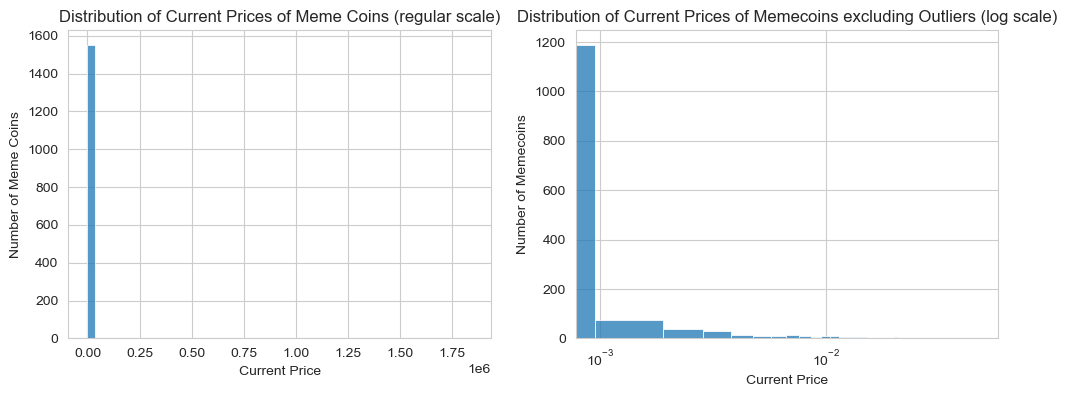

In [468]:
fig, ax  = plt.subplots(1, 2, figsize = (12, 4))

sns.histplot(data = memecoins['current_price'], bins = 50, ax = ax[0])
ax[0].set_title('Distribution of Current Prices of Meme Coins (regular scale)')
ax[0].set(xlabel = 'Current Price', ylabel = 'Number of Meme Coins') 

sns.histplot(data = filtered_outliers['current_price'], bins = 50, ax = ax[1])
ax[1].set_title('Distribution of Current Prices of Memecoins excluding Outliers (log scale)')
ax[1].set(xlabel = 'Current Price', ylabel = 'Number of Memecoins', xscale = 'log')

plt.show()

### Comparing market capitalization for verified and unverified circulating supply

In [427]:
marketcap_data = memecoins.groupby('supply_verified')['market_cap'].describe()
market_cap = pd.DataFrame(marketcap_data)
market_cap.index.name = 'Circulating supply'
market_cap

,count,mean,std,min,25%,50%,75%,max
Circulating supply,,,,,,,,
not verified,1298.0,3.570122e+11,1.271851e+13,2.0,40364.25,171442.0,871962.50,4.581938e+14
verified,208.0,2.212991e+08,1.426044e+09,8670.0,1020813.50,6381332.0,32339512.75,1.760678e+10


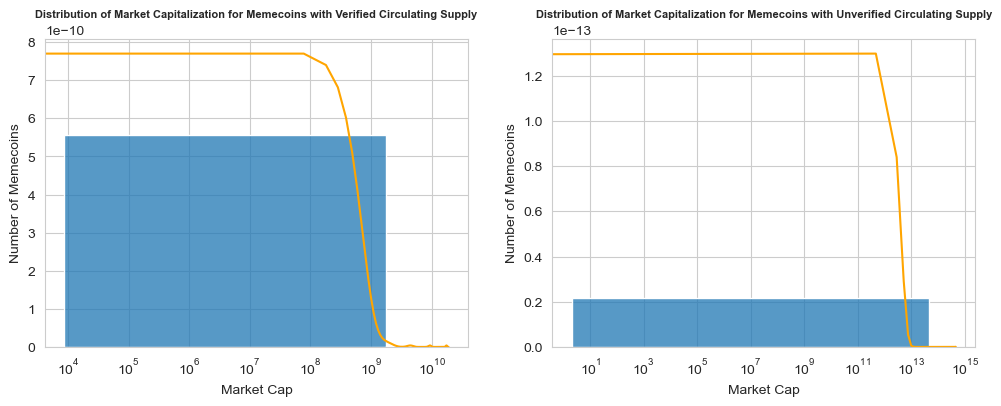

In [428]:
# Vizualizing the market capitalization grouped by that if supply is verified. Using log scale  and KDE to better show the distribution. 
fig, ax = plt.subplots(1, 2 , figsize = (12, 4))
sns.set_style("whitegrid")

sns.histplot(data = verified, x = 'market_cap', bins = 10, stat = 'density' , ax = ax[0])
sns.kdeplot(data = verified, x = 'market_cap', color = 'orange', ax = ax[0])
ax[0].set_title('Distribution of Market Capitalization for Memecoins with Verified Circulating Supply', fontsize = 8, weight = 'bold')


sns.histplot(data = unverified, x = 'market_cap', bins = 10, stat = 'density', ax = ax[1])
sns.kdeplot(data = unverified, x = 'market_cap', color = 'orange', ax = ax[1])
ax[1].set_title('Distribution of Market Capitalization for Memecoins with Unverified Circulating Supply', fontsize = 8, weight = 'bold')

for axis in ax:
    axis.set(xlabel = 'Market Cap', ylabel = 'Number of Memecoins', xscale = 'log');


### Calculating correlation between Market Capitalization and Volume(24h) for verified and unverified memecoins

In [429]:
verified_corr = verified[['market_cap', 'volume_day']].corr().iloc[0, 1]
unverified_corr = unverified[['market_cap', 'volume_day']].corr().iloc[0, 1]

correlation = {'verified' : round(verified_corr, 3), 'unverified' : round(unverified_corr, 3)}

pd.DataFrame(correlation, index = ['Correlation'])

,verified,unverified
Correlation,0.811,-0.005


### Increase between ATH and ATL dividing into compartments and compared between verified and unverified supply

In [430]:
# Calculating increase of ATH vs ATL
verified['price_change_percent'] = (verified['all_time_high'] - verified['all_time_low']) / verified['all_time_low'] * 100
unverified['price_change_percent'] = (unverified['all_time_high'] - unverified['all_time_low']) / unverified['all_time_low'] * 100


# Creating bins for the difference between ATL and ATH to see the distribution of the price change
bins = [0, 100, 1000, 10000, 100000, 1000000, 1e7]
labels = ['0-100%', '100-1,000%', '1,000-10,000%', '10,000-100,000%', '100,000-1,000,000%', '>1,000,000%']

# Calculating the number of meme coins in each bin and the percentage of verified and unverified meme coins in each bin
verified_price_change = pd.cut(verified['price_change_percent'], bins = bins, labels = labels).value_counts()
unverified_price_change = pd.cut(unverified['price_change_percent'], bins = bins, labels = labels).value_counts()

# Coversions to DataFrame and calculation of the percentage of meme coins in each bin
verified_price_change = pd.DataFrame({'Verified' : verified_price_change}).sort_index().T
unverified_price_change = pd.DataFrame({'Unverified' : unverified_price_change}).sort_index().T
price_change_table = pd.concat([verified_price_change, unverified_price_change], axis = 0).T

# Calculating the percentage of meme coins in each bin for each group
price_change_table[['Verified_percentage', 'Unverified_percentage']] = price_change_table[['Verified', 'Unverified']].apply(lambda x: round((x / x.sum() * 100), 2))

price_change_table


,Verified,Unverified,Verified_percentage,Unverified_percentage
price_change_percent,,,,
0-100%,0,24,0.00,1.90
"100-1,000%",30,258,15.71,20.40
"1,000-10,000%",97,681,50.79,53.83
"10,000-100,000%",49,241,25.65,19.05
"100,000-1,000,000%",10,42,5.24,3.32
">1,000,000%",5,19,2.62,1.50


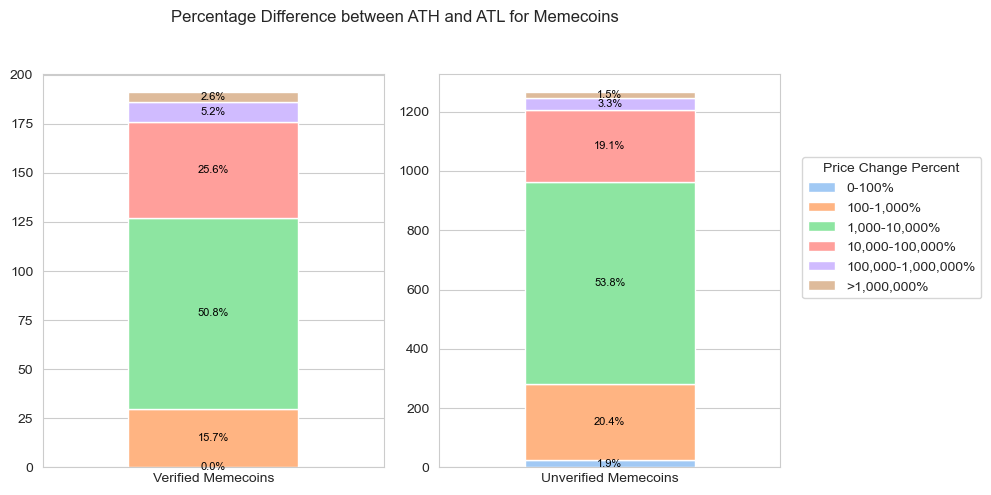

In [467]:
fig, ax = plt.subplots(1, 2 , figsize = (8, 4))

def plot_annotate (ax, col, data, xlabel):
    data.plot(kind = 'bar', stacked = True, color = sns.color_palette("pastel"), figsize = (8, 5), ax = ax)
    ax.get_legend().remove()
    ax.set_xticks([])
    ax.set_xlabel(xlabel)
    for i, rect in enumerate(ax.patches):
        percentage = price_change_table.iloc[i, col]
        ax.annotate(f'{percentage:.1f}%', (rect.get_x() + rect.get_width() / 2, rect.get_y() + rect.get_height() / 2),
                    ha='center', va='center', color='black', fontsize=8)
        
plot_annotate(ax[0], 2, verified_price_change, 'Verified Memecoins')
plot_annotate(ax[1], 3, unverified_price_change, 'Unverified Memecoins')

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, title='Price Change Percent', bbox_to_anchor=(1, 0.7), loc = 'upper left')

fig.suptitle('Percentage Difference between ATH and ATL for Memecoins')
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Market capitalization by Popularity on Watchlists and Circulating Supply Status

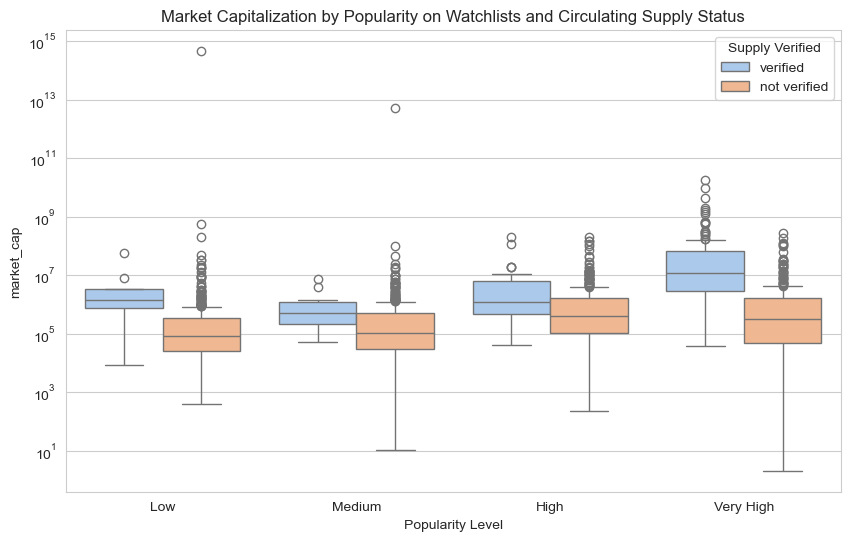

In [437]:
# Adding columns with popularity level counted by pd.qcut() for 4 levels: Low, Medium, High, Very High
memecoins['popularity_lvl'] = pd.qcut(memecoins['popularity_watchlists'], q = 4, labels = ['Low', 'Medium', 'High', 'Very High'])

plt.figure(figsize = (10, 6))

sns.boxplot(data = memecoins, x = 'popularity_lvl', y = 'market_cap', hue = 'supply_verified', palette = 'pastel')

plt.title('Market Capitalization by Popularity on Watchlists and Circulating Supply Status')
plt.xlabel('Popularity Level')

plt.yscale('log') # Log scale to better show the distribution of the market capitalization
plt.legend(title='Supply Verified')
plt.show()

### Selection of Top Memecoins for further analysis

In [358]:
# Choosing top memecoins to further analysis, including only these with verified circulationg supply as they are more reliable

# Using rank to calculate the top memecoins based on Market Capitalization, Popularity, Volume(24h); the lower the rank, the higher the position
verified['rank_market_cap'] = verified['market_cap'].rank(ascending = False)
verified['rank_volume'] = verified['volume_day'].rank(ascending = False)
verified['rank_popularity'] = verified['popularity_watchlists'].rank(ascending = False)

verified['total_rank'] = verified['rank_market_cap'] + verified['rank_volume'] + verified['rank_popularity']

top_memecoins = verified.sort_values('total_rank').head(6)

top_memecoins.iloc[:,[0,2,3,14, 16,17, 18, 19]]

,name,market_cap,volume_day,popularity_watchlists,rank_market_cap,rank_volume,rank_popularity,total_rank
0,Dogecoin,1.760678e+10,675443576.0,1931564.0,1.0,1.0,3.0,5.0
1,Shiba Inu,9.394850e+09,229218347.0,2074704.0,2.0,5.0,2.0,9.0
2,Pepe,4.461763e+09,610203547.0,437401.0,3.0,2.0,6.0,11.0
5,FLOKI,1.508927e+09,185934507.0,423008.0,6.0,6.0,7.0,19.0
3,dogwifhat,1.997920e+09,371202832.0,155667.0,4.0,3.0,13.0,20.0
4,Bonk,1.656968e+09,183254549.0,266408.0,5.0,7.0,8.0,20.0


In [438]:
# Creating the dictionary with selecting cryptocurrencies and their UCID (unique number, which is sued in API endpoint)
selected = {'Bitcoin' : 1, 'Ethereum' : 1027, 'Solana' : 5426}

for i, row in top_memecoins.iterrows():
    selected[row['name']] = row['ucid']

In [389]:
def fetch_api_data(ucid):
    '''
    This function fetches the data from the API endpoint for the given meme coin.

    Args:
        ucid (int): The unique coin identifier for the meme coin.

    Returns:
        DataFrame: The DataFrame containing the data fetched from the API.
    '''
    # Fetching the data from the API using different UCID for each meme coin
    api_coin_data = f'https://api.coinmarketcap.com/data-api/v3/cryptocurrency/detail/chart?id={ucid}&range=1Y'
    
    try:
        # Fetching the data from the API and checking if the response is correct
        api_data = requests.get(api_coin_data)
        api_data.raise_for_status()
        # Converting JSON response into a Python dictionary and extracting the 'points'
        data = api_data.json()
        points = data['data']['points']

        data_list = []
        # Iterating through the points and extracting the timestamp, price, volume, and market cap
        for timestamp, values in points.items():
            timestamp = int(timestamp)
            price = values['v'][0]
            volume = values['v'][1]
            market_cap = values['v'][2]
            data_list.append([timestamp, price, volume, market_cap])

        return pd.DataFrame(data_list, columns=['timestamp', 'price', 'volume', 'market_cap'])

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None
    

In [390]:
# Creating an empty Data Frame
df_api = pd.DataFrame(columns=['timestamp', 'price', 'volume', 'market_cap'])

# Itereting through selected dictionary and using fetch_api_data() function to get the data for each meme coin
for name, ucid in selected.items():
    api_data = fetch_api_data(ucid)
    api_data['name'] = name
    df_api = pd.concat([df_api, api_data.dropna(how = 'all')], ignore_index=True)
    

# Converting the timestamp to datetime format
df_api['date'] = pd.to_datetime(df_api['timestamp'], unit='s')
df_api = df_api.drop(columns = ['timestamp'])

/var/folders/2b/zd6d4xm94jg8lk458s4_tv2r0000gn/T/ipykernel_15022/399311290.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_api = pd.concat([df_api, api_data.dropna(how = 'all')], ignore_index=True)


### Price fluctuations over the 1 year period

In [364]:
# Counting the trend line for the bitcoin to use it in plot

bitcoin = df_api[df_api['name'] == 'Bitcoin'].copy()
bitcoin['date_num'] = (bitcoin['date'] - bitcoin['date'].min()).dt.days

fit = np.polyfit(bitcoin['date_num'], bitcoin['price'], deg = 1)

fitted_data = [fit[0] * x + fit[1] for x in bitcoin['date_num']]

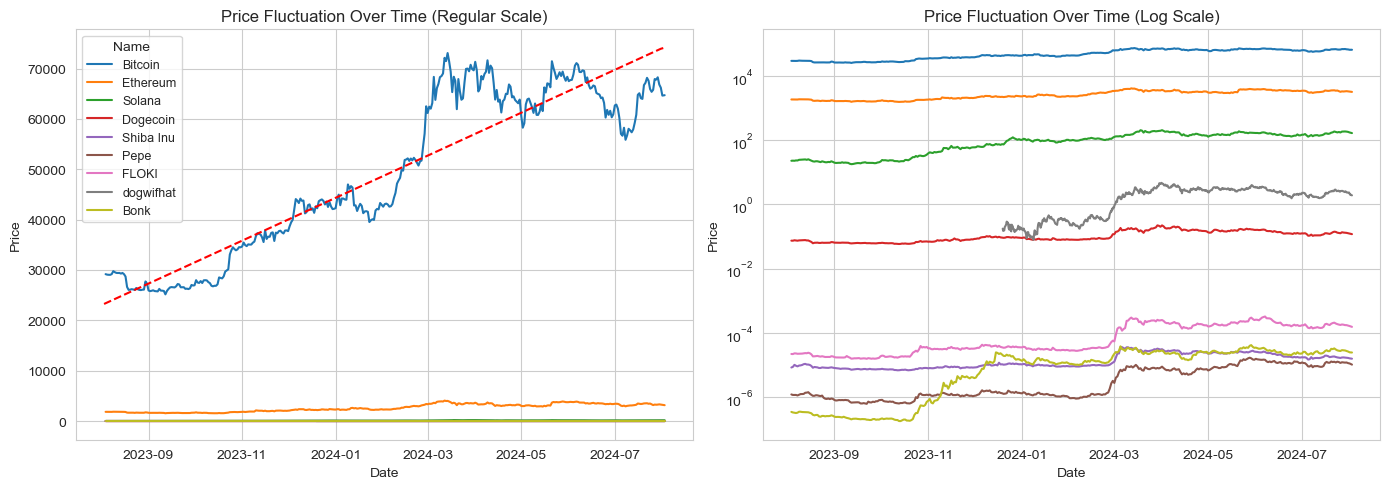

In [460]:
# Plot the line plot for the price fluctuations

fig, ax = plt.subplots(1, 2, figsize = (14,5))

sns.lineplot(data= df_api, x = 'date', y = 'price', hue = 'name', ax = ax[0])
ax[0].plot(bitcoin['date'], fitted_data, color = 'red', linestyle = '--')
ax[0].set_title('Price Fluctuation Over Time (Regular Scale)')
ax[0].set(xlabel = 'Date', ylabel = 'Price')
ax[0].legend(title='Name', prop={'size': 9})

sns.lineplot(data= df_api, x = 'date', y = 'price', hue = 'name', ax = ax[1])
ax[1].set_title('Price Fluctuation Over Time (Log Scale)')
ax[1].set(xlabel = 'Date', ylabel = 'Price')
ax[1].get_legend().remove()
plt.yscale('log')

plt.tight_layout()
plt.show()

### Comparing Market Capitalization in 1 year period between selected memecoins and Bitcoin, Etherum, Solana

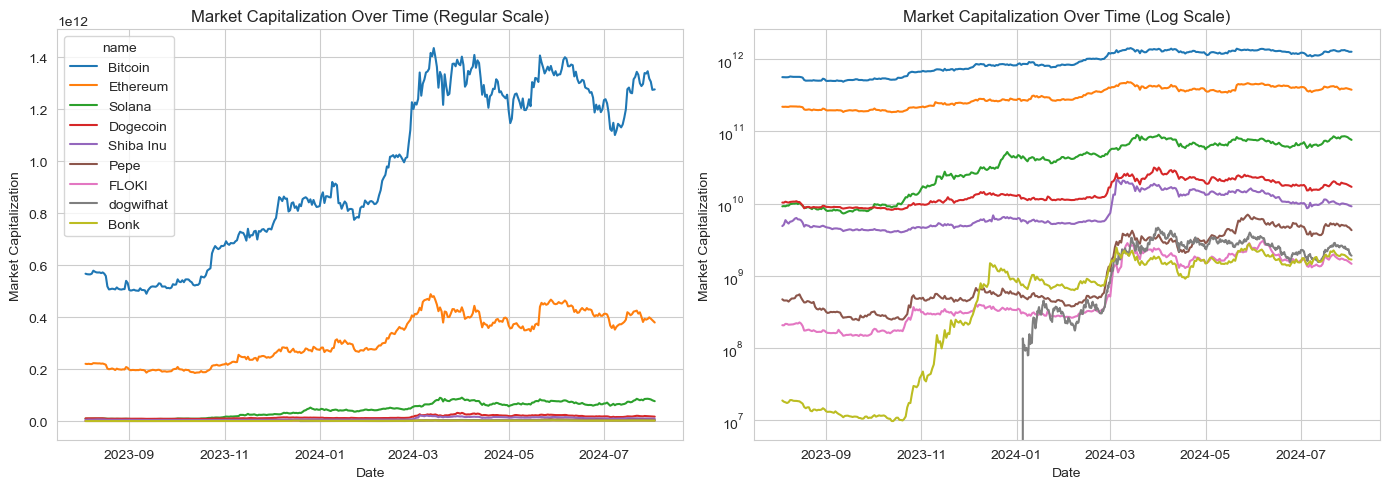

In [461]:
# Plot the line plot for the Market Capitalization during 1 last year
fig, ax = plt.subplots(1, 2, figsize = (14, 5))

sns.lineplot(data= df_api, x = 'date', y = 'market_cap', hue = 'name', ax = ax[0])
ax[0].set_title('Market Capitalization Over Time (Regular Scale)')
ax[0].set(xlabel = 'Date', ylabel = 'Market Capitalization')

sns.lineplot(data= df_api, x = 'date', y = 'market_cap', hue = 'name', ax = ax[1])
ax[1].set_title('Market Capitalization Over Time (Log Scale)')
ax[1].set(xlabel = 'Date', ylabel = 'Market Capitalization')
ax[1].get_legend().remove()
plt.yscale('log')

plt.tight_layout()
plt.show()

### Correlation between selected cryptocurrencies

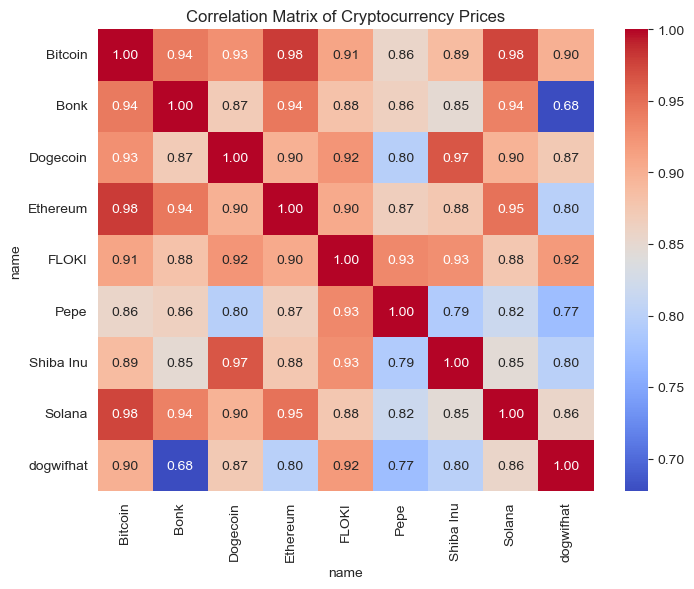

In [367]:
# Preparing the data for correlation map
df_grouped = df_api.pivot_table(index='date', columns='name', values='price')

correlation_matrix = df_grouped.corr()

# Plot heat map based on the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.index)
plt.title('Correlation Matrix of Cryptocurrency Prices')

plt.show()